In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

file_path = "/content/drive/My Drive/Colab_Notebooks/data/full_embedding_15K.pkl"
df = pd.read_pickle(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'year', 'month', 'day', 'author', 'title',
       'article', 'url', 'publication', 'F100', 'bert_embedding',
       'bert_F100_embedding', 'agnostic_title_embedding',
       'agnostic_bert_F100_embedding'],
      dtype='object')

#Normalization


In [ ]:
from sklearn.preprocessing import normalize

agnostic_matrix = np.array(df['agnostic_title_embedding'].tolist())

# נורמליזציה של הנתונים כך שכל וקטור יהיה באורך 1 (L2 normalization)
N_agnostic_title_embeddings = normalize(agnostic_matrix, norm='l2')
df['N_agnostic_title_embeddings'] = N_agnostic_title_embeddings.tolist()

PCA

📌 גודל הנתונים אחרי PCA: (15000, 50)


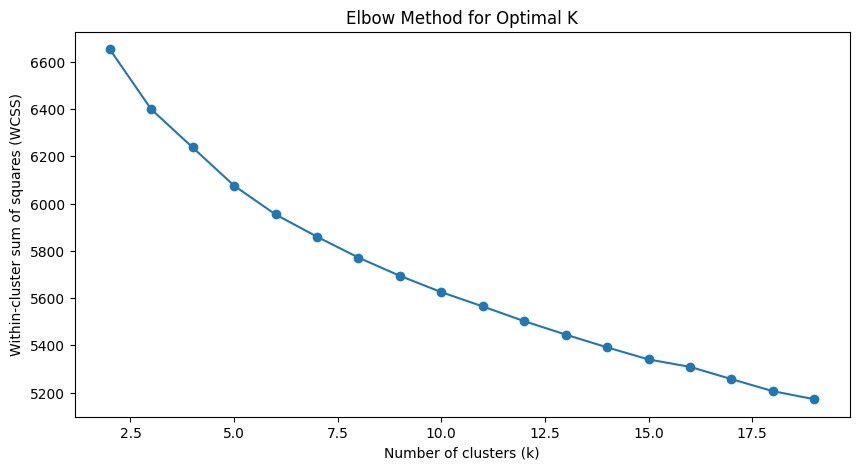

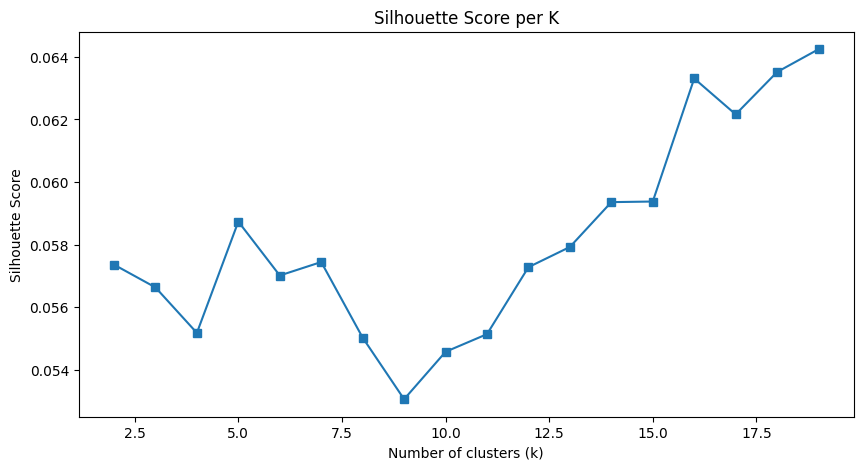

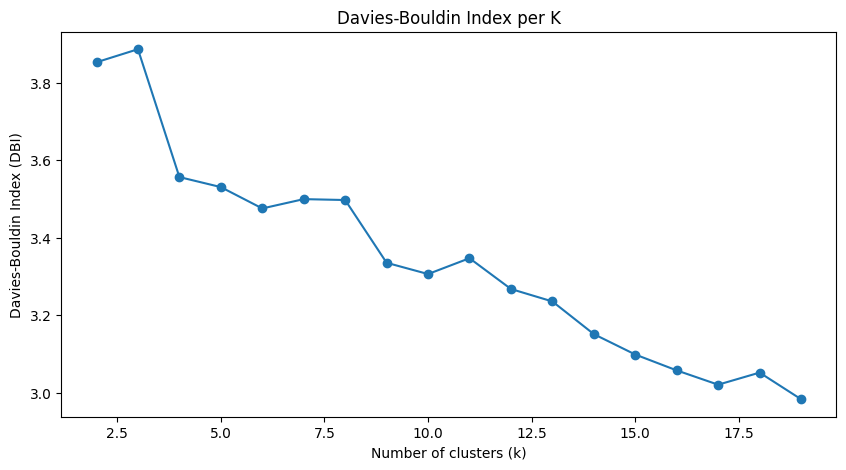

📌 גודל הנתונים אחרי PCA: (15000, 30)


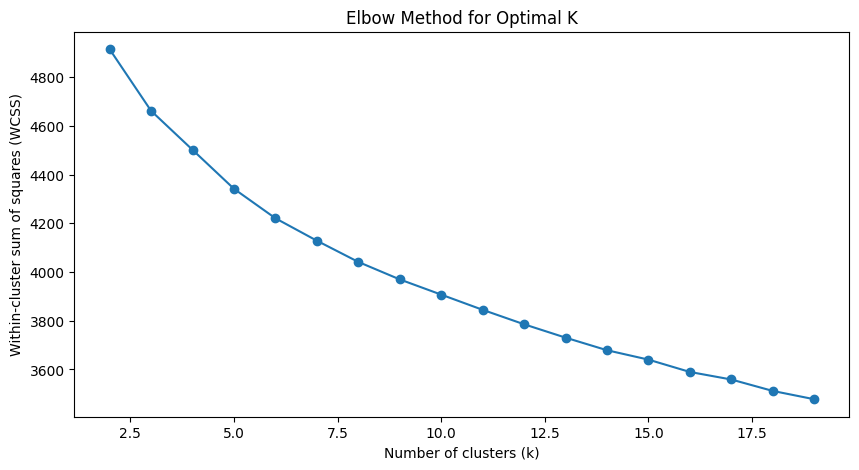

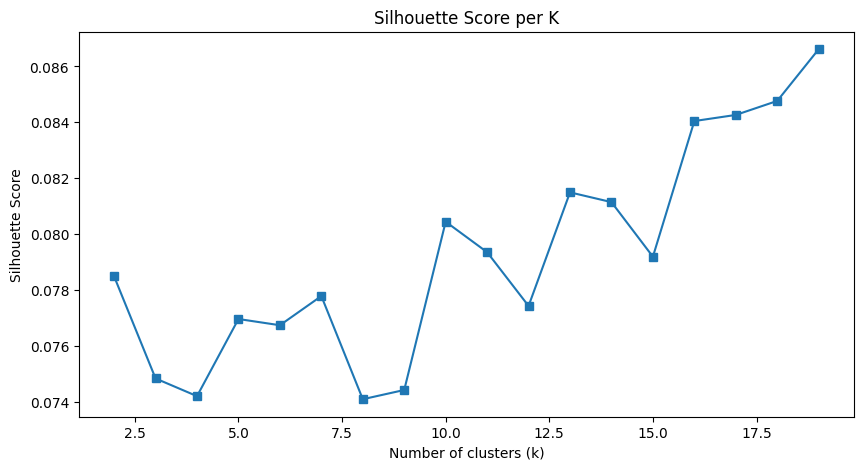

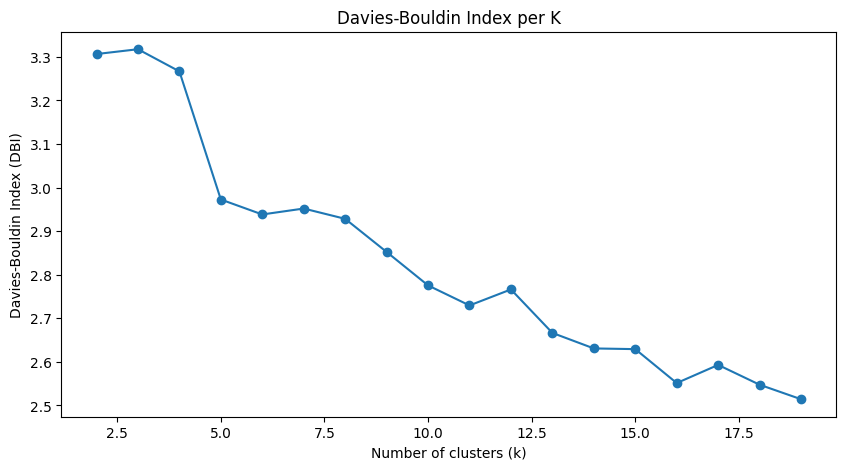

📌 גודל הנתונים אחרי PCA: (15000, 10)


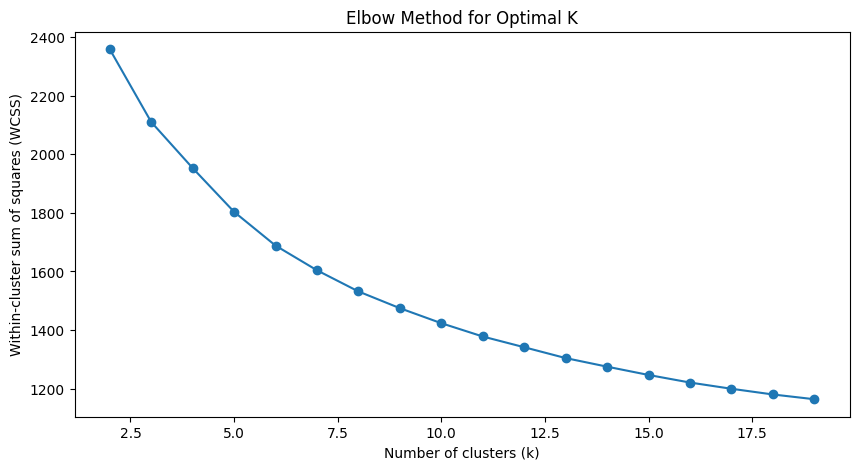

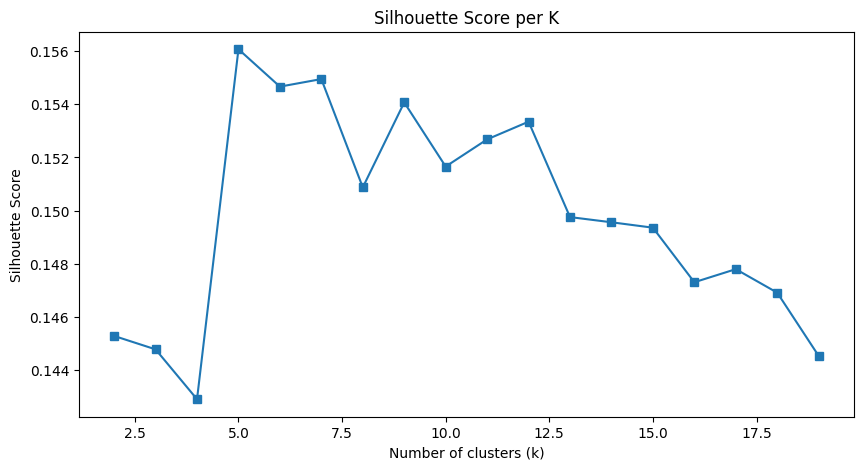

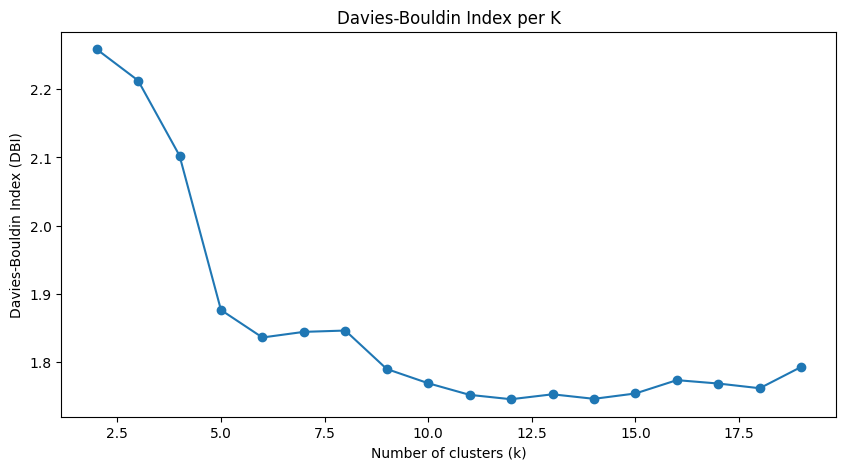

📌 גודל הנתונים אחרי PCA: (15000, 6)


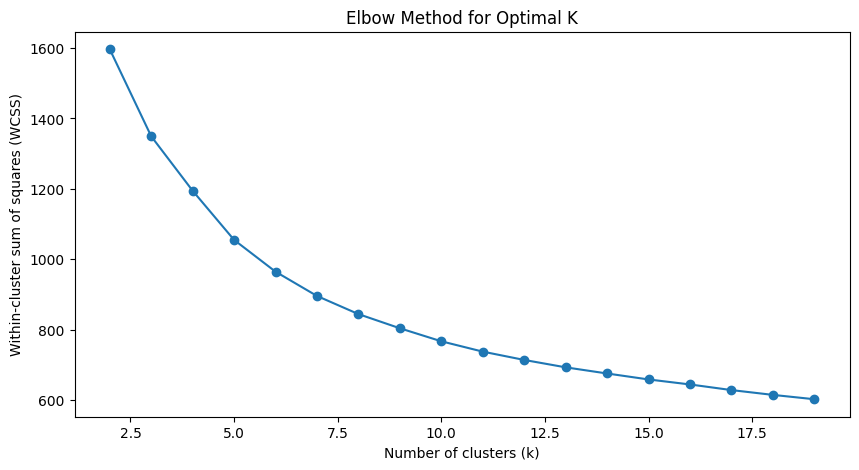

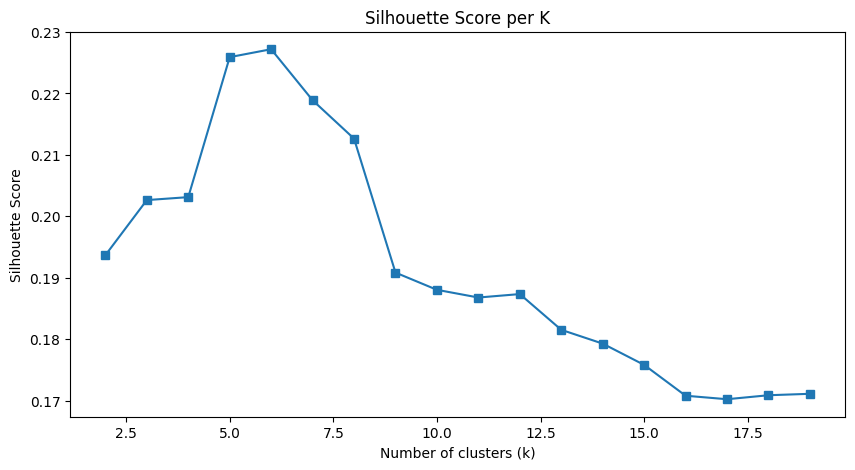

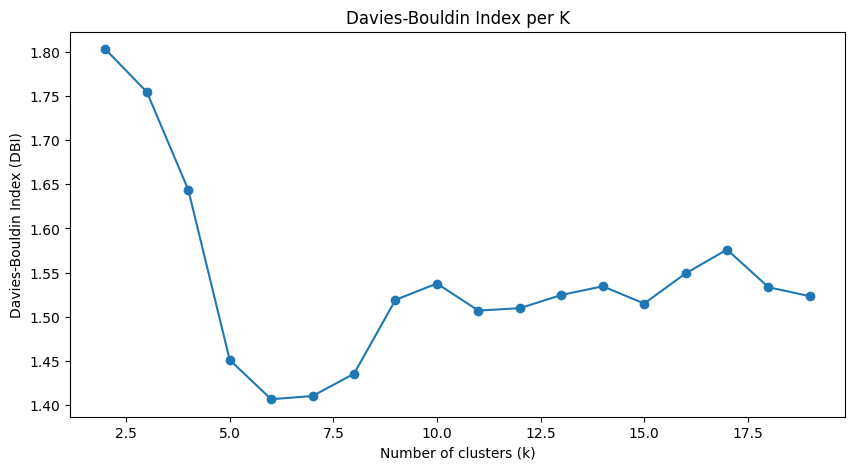

📌 גודל הנתונים אחרי PCA: (15000, 5)


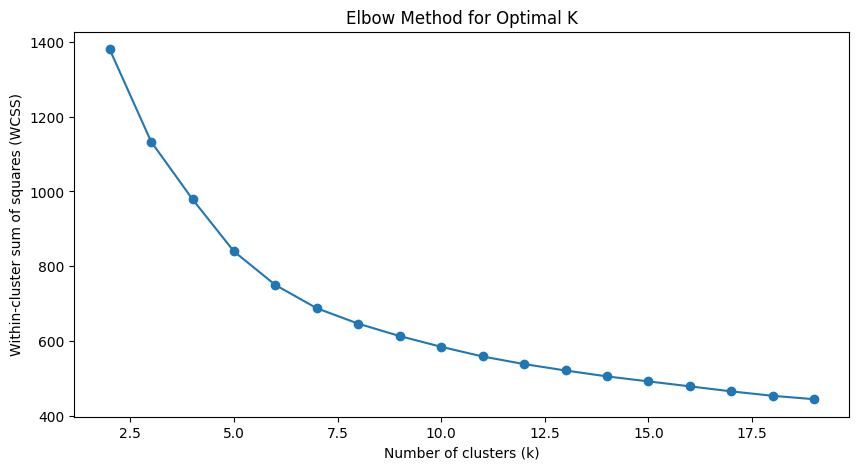

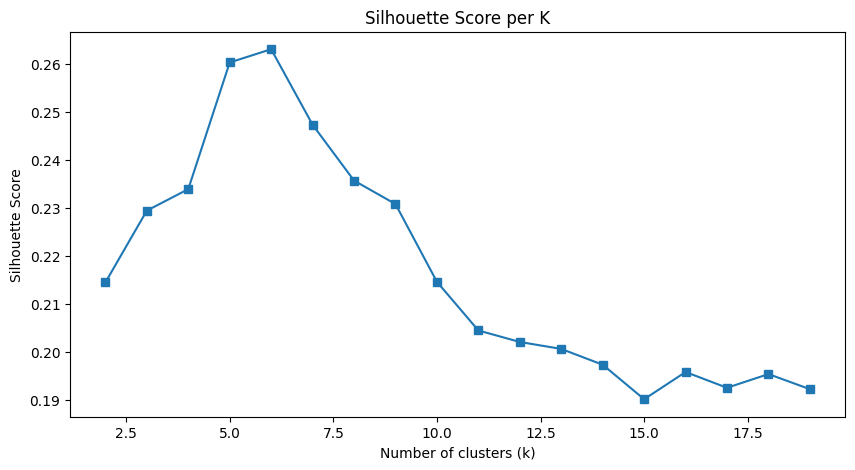

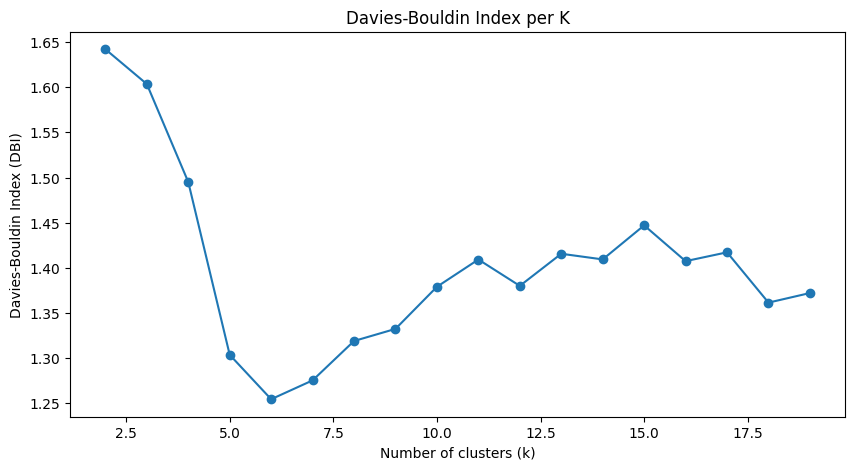

In [ ]:
from sklearn.decomposition import PCA
n_components = [50,30,10,6,5]

for n in n_components:
  pca = PCA(n)  # נוריד את הממדים ל-50 כדי לשמור מידע חשוב
  reduced_embeddings = pca.fit_transform(N_agnostic_title_embeddings)
  print(f"📌 גודל הנתונים אחרי PCA: {reduced_embeddings.shape}")


  from sklearn.cluster import KMeans
  import matplotlib.pyplot as plt
  from sklearn.metrics import davies_bouldin_score

  # טווח מספרי הקלסטרים לבדיקה
  k_range = range(2, 20)
  wcss = []  # Within-cluster sum of squares

  for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
      kmeans.fit(reduced_embeddings)  # נריץ את זה על ה-BERT embeddings
      wcss.append(kmeans.inertia_)

  # ציור גרף Elbow
  plt.figure(figsize=(10,5))
  plt.plot(k_range, wcss, marker='o', linestyle='-')
  plt.xlabel("Number of clusters (k)")
  plt.ylabel("Within-cluster sum of squares (WCSS)")
  plt.title("Elbow Method for Optimal K")
  plt.show()


  sil_scores = []

  for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
      labels = kmeans.fit_predict(reduced_embeddings)
      sil_scores.append(silhouette_score(reduced_embeddings, labels))

  # ציור גרף Silhouette Score
  plt.figure(figsize=(10,5))
  plt.plot(k_range, sil_scores, marker='s', linestyle='-')
  plt.xlabel("Number of clusters (k)")
  plt.ylabel("Silhouette Score")
  plt.title("Silhouette Score per K")
  plt.show()

  db_scores = []

  for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
      labels = kmeans.fit_predict(reduced_embeddings)
      db_scores.append(davies_bouldin_score(reduced_embeddings, labels))

  # ציור גרף Davies-Bouldin Index
  plt.figure(figsize=(10,5))
  plt.plot(k_range, db_scores, marker='o', linestyle='-')
  plt.xlabel("Number of clusters (k)")
  plt.ylabel("Davies-Bouldin Index (DBI)")
  plt.title("Davies-Bouldin Index per K")
  plt.show()


In [ ]:
## 5 pca 6 clusters .

In [ ]:
n_components = [5]

for n in n_components:
  pca = PCA(n)
  reduced_embeddings = pca.fit_transform(N_agnostic_title_embeddings)
  print(f"📌 גודל הנתונים אחרי PCA: {reduced_embeddings.shape}")


kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df['ag_title_cluster'] = kmeans.fit_predict(reduced_embeddings)
df.columns

📌 גודל הנתונים אחרי PCA: (15000, 5)


Index(['Unnamed: 0.1', 'Unnamed: 0', 'year', 'month', 'day', 'author', 'title',
       'article', 'url', 'publication', 'F100', 'agnostic_title_embedding',
       'N_agnostic_title_embeddings', 'ag_title_cluster'],
      dtype='object')

In [ ]:
from collections import Counter
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# הגדרת רשימת stopwords באנגלית
stop_words = set(stopwords.words('english'))

# יצירת מילון לכל קלסטר
cluster_keywords = {}

for cluster_id in df['ag_title_cluster'].unique():
    cluster_texts = df[df['ag_title_cluster'] == cluster_id]['title'].dropna()
    all_words = " ".join(cluster_texts).lower().split()  # מחברים את כל הטקסטים ומפרקים למילים

    # מסירים stopwords
    filtered_words = [word for word in all_words if word not in stop_words and len(word) > 2]

    # סופרים את המילים הנפוצות
    word_counts = Counter(filtered_words)
    most_common_words = word_counts.most_common(20)  # 5 המילים הנפוצות ביותר

    cluster_keywords[cluster_id] = most_common_words

# יצירת טבלה עם הנושאים לכל קלסטר
df_topics = pd.DataFrame.from_dict(cluster_keywords, orient='index', columns=[f'Word_{i+1}' for i in range(20)])

# הצגת הנתונים
display(df_topics)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10,Word_11,Word_12,Word_13,Word_14,Word_15,Word_16,Word_17,Word_18,Word_19,Word_20
4,"(new, 287)","(christmas, 167)","(2019, 139)","(says, 124)","(best, 123)","(first, 114)","(star, 79)","(holiday, 77)","(review:, 71)","(year, 70)","(2020, 60)","(watch, 60)","(time, 60)","(amazon, 55)","(opinion, 55)","(one, 52)","(life, 50)","(home, 49)","(game, 48)","(film, 48)"
3,"(trump, 461)","(impeachment, 348)","(house, 137)","(says, 129)","(democrats, 101)","(trump's, 99)","(u.s., 94)","((opinion), 92)","(election, 86)","(opinion, 73)","(senate, 72)","(white, 69)","(2020, 68)","(democratic, 68)","(campaign, 64)","(donald, 63)","(debate, 58)","(trial, 54)","(vote, 52)","(johnson, 51)"
2,"(u.s., 237)","(court, 177)","(says, 164)","(new, 129)","(case, 102)","(million, 77)","(police, 70)","(accused, 67)","(judge, 65)","(man, 62)","(supreme, 58)","(california, 58)","(trump, 55)","(law, 53)","(circuit, 51)","(former, 49)","(boeing, 48)","(ceo, 47)","(say, 47)","(drug, 44)"
5,"(new, 171)","(says, 134)","(u.s., 118)","(climate, 94)","(police, 81)","(protests, 77)","(hong, 73)","(kong, 66)","(opinion, 62)","(zealand, 61)","(south, 54)","(government, 53)","(killed, 53)","(korea, 48)","(attack, 48)","(citizenship, 48)","(volcano, 48)","(north, 47)","(people, 46)","(change, 45)"
0,"(no., 153)","(past, 138)","(win, 136)","(state, 104)","(leads, 48)","(straight, 40)","(rout, 37)","(streak, 34)","(lead, 32)","(top, 30)","(season, 29)","(texas, 27)","(helps, 27)","(lifts, 27)","(late, 26)","(kings, 25)","(scores, 25)","(dies, 24)","(loss, 24)","(florida, 23)"
1,"(trade, 482)","(u.s., 356)","(deal, 270)","(china, 219)","(global, 200)","(new, 190)","(oil, 182)","(shares, 172)","(update, 169)","(says, 127)","(2020, 121)","(stocks, 120)","(billion, 119)","(bank, 110)","(sources, 110)","(market, 101)","(record, 101)","(dollar, 90)","(u.s.-china, 79)","(economy, 79)"


In [ ]:
n_components = [5]

for n in n_components:
  pca = PCA(n)
  reduced_embeddings = pca.fit_transform(N_agnostic_title_embeddings)
  print(f"📌 גודל הנתונים אחרי PCA: {reduced_embeddings.shape}")


kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df['ag_title_cluster'] = kmeans.fit_predict(reduced_embeddings)
df.columns
nltk.download('stopwords')

# הגדרת רשימת stopwords באנגלית
stop_words = set(stopwords.words('english'))

# יצירת מילון לכל קלסטר
cluster_keywords = {}

for cluster_id in df['ag_title_cluster'].unique():
    cluster_texts = df[df['ag_title_cluster'] == cluster_id]['title'].dropna()
    all_words = " ".join(cluster_texts).lower().split()  # מחברים את כל הטקסטים ומפרקים למילים

    # מסירים stopwords
    filtered_words = [word for word in all_words if word not in stop_words and len(word) > 2]

    # סופרים את המילים הנפוצות
    word_counts = Counter(filtered_words)
    most_common_words = word_counts.most_common(20)  # 5 המילים הנפוצות ביותר

    cluster_keywords[cluster_id] = most_common_words

# יצירת טבלה עם הנושאים לכל קלסטר
df_topics = pd.DataFrame.from_dict(cluster_keywords, orient='index', columns=[f'Word_{i+1}' for i in range(20)])

# הצגת הנתונים
display(df_topics)



📌 גודל הנתונים אחרי PCA: (15000, 5)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10,Word_11,Word_12,Word_13,Word_14,Word_15,Word_16,Word_17,Word_18,Word_19,Word_20
4,"(new, 287)","(christmas, 167)","(2019, 139)","(says, 124)","(best, 123)","(first, 114)","(star, 79)","(holiday, 77)","(review:, 71)","(year, 70)","(2020, 60)","(watch, 60)","(time, 60)","(amazon, 55)","(opinion, 55)","(one, 52)","(life, 50)","(home, 49)","(game, 48)","(film, 48)"
3,"(trump, 461)","(impeachment, 348)","(house, 137)","(says, 129)","(democrats, 101)","(trump's, 99)","(u.s., 94)","((opinion), 92)","(election, 86)","(opinion, 73)","(senate, 72)","(white, 69)","(2020, 68)","(democratic, 68)","(campaign, 64)","(donald, 63)","(debate, 58)","(trial, 54)","(vote, 52)","(johnson, 51)"
2,"(u.s., 237)","(court, 177)","(says, 164)","(new, 129)","(case, 102)","(million, 77)","(police, 70)","(accused, 67)","(judge, 65)","(man, 62)","(supreme, 58)","(california, 58)","(trump, 55)","(law, 53)","(circuit, 51)","(former, 49)","(boeing, 48)","(ceo, 47)","(say, 47)","(drug, 44)"
5,"(new, 171)","(says, 134)","(u.s., 118)","(climate, 94)","(police, 81)","(protests, 77)","(hong, 73)","(kong, 66)","(opinion, 62)","(zealand, 61)","(south, 54)","(government, 53)","(killed, 53)","(korea, 48)","(attack, 48)","(citizenship, 48)","(volcano, 48)","(north, 47)","(people, 46)","(change, 45)"
0,"(no., 153)","(past, 138)","(win, 136)","(state, 104)","(leads, 48)","(straight, 40)","(rout, 37)","(streak, 34)","(lead, 32)","(top, 30)","(season, 29)","(texas, 27)","(helps, 27)","(lifts, 27)","(late, 26)","(kings, 25)","(scores, 25)","(dies, 24)","(loss, 24)","(florida, 23)"
1,"(trade, 482)","(u.s., 356)","(deal, 270)","(china, 219)","(global, 200)","(new, 190)","(oil, 182)","(shares, 172)","(update, 169)","(says, 127)","(2020, 121)","(stocks, 120)","(billion, 119)","(bank, 110)","(sources, 110)","(market, 101)","(record, 101)","(dollar, 90)","(u.s.-china, 79)","(economy, 79)"


looks like the cluster divide the topics good
cluster 0 : general news
cluster 1 : climate
cluster 2 : politics
cluster 3 : sports
cluster 4: economics

ag_title_cluster
4    3819
1    3329
5    2570
2    2393
3    1682
0    1207
Name: count, dtype: int64


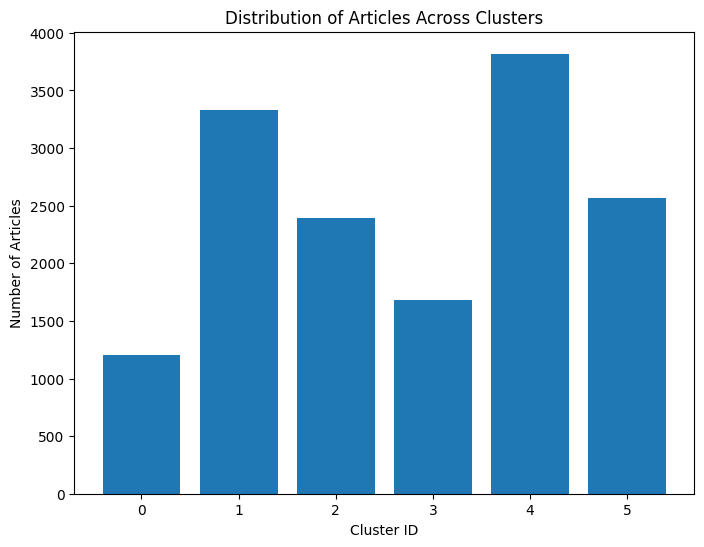

In [ ]:

df['ag_title_cluster'].value_counts()
cluster_sizes = df['ag_title_cluster'].value_counts()
print(cluster_sizes)
plt.figure(figsize=(8, 6))
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Articles")
plt.title("Distribution of Articles Across Clusters")
plt.show()


In [ ]:
df.to_pickle('/content/drive/My Drive/Colab_Notebooks/data/full_clustered.pkl')